In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

X_test = np.load("/content/drive/MyDrive/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project/person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

X_train_valid = X_train_valid[:, :, :500]
X_test = X_test[:, :, :500]


# modify labels to be 0-3
y_train_valid -= 769
y_test -= 769


ind_valid = np.random.choice(2115, 300, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(X_train, X_val) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_val) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',X_train.shape)
print('Shape of validation set:',X_val.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_val.shape)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).view(-1, 22, 500), torch.from_numpy(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).view(-1, 22, 500), torch.from_numpy(y_val))
X_test = torch.from_numpy(X_test).view(-1, 22, 500)
y_test = torch.from_numpy(y_test)


Mounted at /content/drive
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
Shape of training set: (1815, 22, 500)
Shape of validation set: (300, 22, 500)
Shape of training labels: (1815,)
Shape of validation labels: (300,)


## GRU
3 GRU Blocks achieve 68.4% accuracy

In [25]:
class SmallBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=False, norm=False):
        super(SmallBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # GRU -> ReLU -> (BatchNorm1d) -> MaxPool1d -> Dropout
        self.gru1 = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.relu1(x)
        x = self.maxpool1(x.permute(0, 2, 1)).permute(0, 2, 1)

        if self.norm:
            x = self.bn1(x.permute(0, 2, 1)).permute(0, 2, 1)
        if self.dropout:
            x = self.drop1(x)
        return x

class BasicGRU(nn.Module):
    def __init__(self, input_size=22, hidden_size=128, num_layers=1, num_classes=4):
        super(BasicGRU, self).__init__()

        # GRU layers
        self.block1 = SmallBlock(22, 128, dropout=True, norm=False)
        self.block2 = SmallBlock(128, 256, dropout=True, norm=False)
        self.block3 = SmallBlock(256, 512, dropout=True, norm=True)
        self.output = nn.Linear(512 * 18, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Forward propagate GRU
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.reshape(x.size(0), -1)
        x = self.output(x)

        return x


In [26]:
model = BasicGRU().to(device)
bsz, num_channels, width = 64, 22, 500
test_input = torch.randn(bsz, num_channels, width).to(device)

print(model(test_input).shape)

def weights_init(m):
    if isinstance(m, (nn.GRU, nn.Linear)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

model.apply(weights_init)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

num_epochs = 50
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()


    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")

torch.Size([64, 4])
Epoch 1, Train loss: 2.108, Train acc: 0.312, Val loss: 1.237, Val acc: 0.447
Epoch 2, Train loss: 1.780, Train acc: 0.415, Val loss: 1.775, Val acc: 0.353
Epoch 3, Train loss: 1.505, Train acc: 0.470, Val loss: 1.749, Val acc: 0.390
Epoch 4, Train loss: 1.351, Train acc: 0.509, Val loss: 1.412, Val acc: 0.433
Epoch 5, Train loss: 1.242, Train acc: 0.525, Val loss: 1.432, Val acc: 0.437
Epoch 6, Train loss: 1.166, Train acc: 0.548, Val loss: 1.448, Val acc: 0.423
Epoch 7, Train loss: 1.080, Train acc: 0.587, Val loss: 1.263, Val acc: 0.507
Epoch 8, Train loss: 1.021, Train acc: 0.613, Val loss: 1.068, Val acc: 0.560
Epoch 9, Train loss: 0.962, Train acc: 0.631, Val loss: 1.018, Val acc: 0.540
Epoch 10, Train loss: 0.943, Train acc: 0.640, Val loss: 0.956, Val acc: 0.583
Epoch 11, Train loss: 0.849, Train acc: 0.671, Val loss: 1.077, Val acc: 0.547
Epoch 12, Train loss: 0.840, Train acc: 0.668, Val loss: 1.014, Val acc: 0.573
Epoch 13, Train loss: 0.841, Train acc: 0

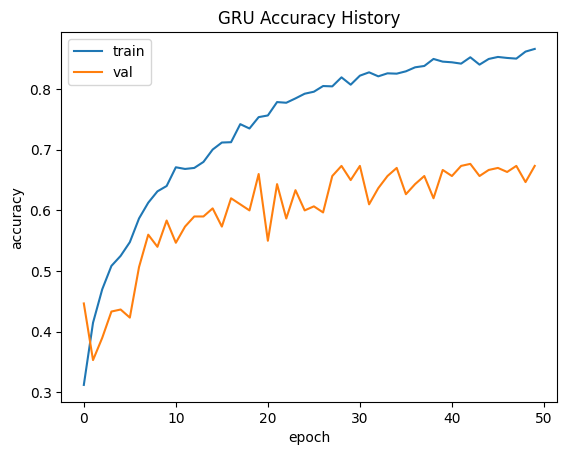

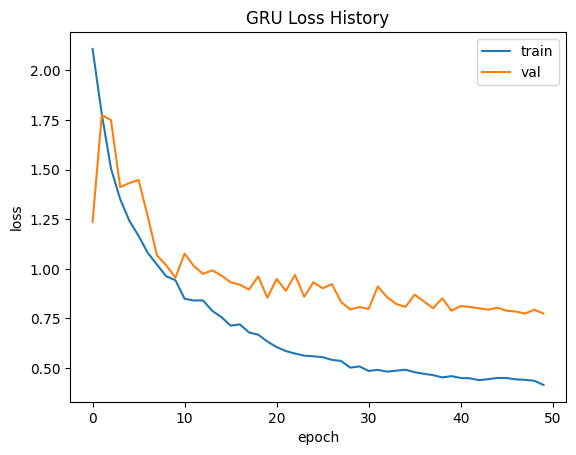

In [27]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('GRU Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('GRU Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [28]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 0.807, Test acc: 0.684


## CNN + GRU 1
2 Conv blocks and 1 GRU block achieve 63% accuracy.

In [7]:
class SmallConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, norm=False, dropout=False):
        super(SmallConvBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # conv -> relu -> pool -> (batch norm) -> (dropout)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        if (self.norm):
            x = self.bn1(x)
        if (self.dropout):
            x = self.drop1(x)
        return x

class SmallBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=False, norm=False):
        super(SmallBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # GRU -> ReLU -> (BatchNorm1d) -> MaxPool1d -> Dropout
        self.gru1 = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.relu1(x)
        x = self.maxpool1(x.permute(0, 2, 1)).permute(0, 2, 1)

        if self.norm:
            x = self.bn1(x.permute(0, 2, 1)).permute(0, 2, 1)
        if self.dropout:
            x = self.drop1(x)
        return x

class CNNGRU1(nn.Module):
    def __init__(self, input_size=22, hidden_size=128, num_layers=1, num_classes=4):
        super(CNNGRU1, self).__init__()

        # GRU layers
        self.cblock1 = SmallConvBlock(22, 128, dropout=True, norm=False)
        self.cblock2 = SmallConvBlock(128, 256, dropout=True, norm=True)
        self.gru1 = SmallBlock(256, 512, dropout=True, norm=False)
        self.output = nn.Linear(512 * 18, num_classes)

    def forward(self, x):
        x = self.cblock1(x)
        x = self.cblock2(x)

        x = x.permute(0, 2, 1)
        x = self.gru1(x)
        x = x.reshape(x.size(0), -1)
        x = self.output(x)
        return x
        return x


In [36]:
model = CNNGRU1().to(device)
bsz, num_channels, width = 64, 22, 500
test_input = torch.randn(bsz, num_channels, width).to(device)

print(model(test_input).shape)

def weights_init(m):
    if isinstance(m, (nn.GRU, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

model.apply(weights_init)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

num_epochs = 100
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()


    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")

torch.Size([64, 4])
Epoch 1, Train loss: 1.493, Train acc: 0.318, Val loss: 1.325, Val acc: 0.310
Epoch 2, Train loss: 1.290, Train acc: 0.412, Val loss: 1.485, Val acc: 0.270
Epoch 3, Train loss: 1.149, Train acc: 0.496, Val loss: 1.139, Val acc: 0.520
Epoch 4, Train loss: 1.107, Train acc: 0.531, Val loss: 1.132, Val acc: 0.497
Epoch 5, Train loss: 1.092, Train acc: 0.539, Val loss: 1.093, Val acc: 0.533
Epoch 6, Train loss: 1.045, Train acc: 0.574, Val loss: 1.118, Val acc: 0.497
Epoch 7, Train loss: 1.054, Train acc: 0.568, Val loss: 1.142, Val acc: 0.540
Epoch 8, Train loss: 1.021, Train acc: 0.579, Val loss: 1.075, Val acc: 0.553
Epoch 9, Train loss: 1.004, Train acc: 0.587, Val loss: 1.097, Val acc: 0.477
Epoch 10, Train loss: 1.014, Train acc: 0.595, Val loss: 1.012, Val acc: 0.620
Epoch 11, Train loss: 0.992, Train acc: 0.598, Val loss: 1.028, Val acc: 0.617
Epoch 12, Train loss: 0.976, Train acc: 0.618, Val loss: 1.100, Val acc: 0.487
Epoch 13, Train loss: 0.984, Train acc: 0

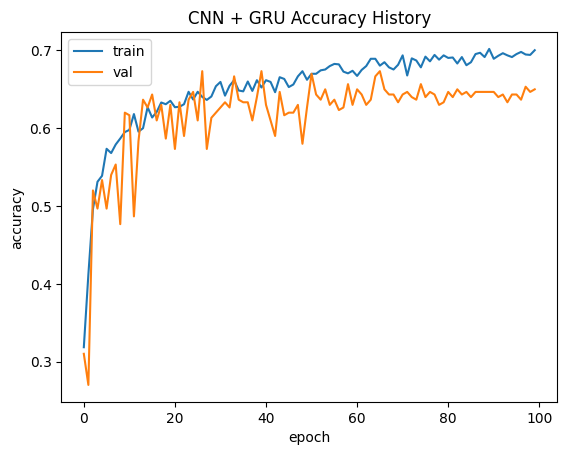

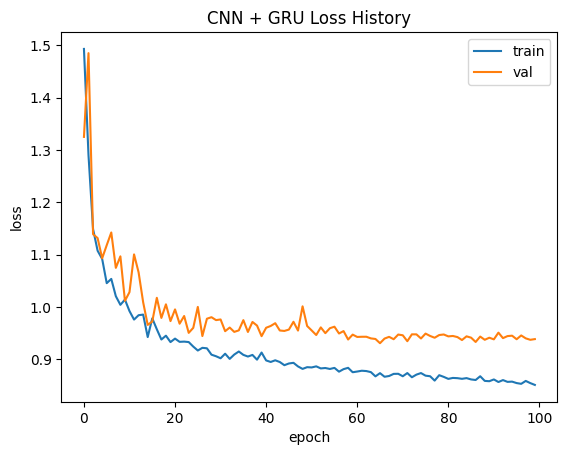

In [37]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN + GRU Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN + GRU Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [38]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 0.972, Test acc: 0.630


## CNN + GRU 2
3 conv blocks and 1 GRU block achieve 67.7% accuracy

In [8]:
class CNNGRU2(nn.Module):
    def __init__(self):
        super(CNNGRU2, self).__init__()

        # start: 22 x 500
        self.cblock1 = SmallConvBlock(22, 128, 5, dropout=True, norm=False)
        self.cblock2 = SmallConvBlock(128, 256, 5, dropout=True, norm=True)
        self.cblock3 = SmallConvBlock(256, 512, dropout=True, norm=False)
        self.gru1 = SmallBlock(512, 1024, dropout=True, norm=True)
        self.output = nn.Linear(1024 * 6, 4)

    def forward(self, x):
        x = self.cblock1(x)
        x = self.cblock2(x)
        x = self.cblock3(x)

        x = x.permute(0, 2, 1)
        x = self.gru1(x)
        x = x.reshape(x.size(0), -1)
        x = self.output(x)
        return x

def weights_init(m):
    if isinstance(m, (nn.GRU, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

In [9]:
model = CNNGRU2().to(device)
bsz, num_channels, width = 64, 22, 500
test_input = torch.randn(bsz, num_channels, width).to(device)

print(model(test_input).shape)

def weights_init(m):
    if isinstance(m, (nn.GRU, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

model.apply(weights_init)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

num_epochs = 100
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()


    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")

torch.Size([64, 4])
Epoch 1, Train loss: 2.284, Train acc: 0.287, Val loss: 1.757, Val acc: 0.273
Epoch 2, Train loss: 1.993, Train acc: 0.315, Val loss: 1.697, Val acc: 0.323
Epoch 3, Train loss: 1.749, Train acc: 0.327, Val loss: 1.635, Val acc: 0.333
Epoch 4, Train loss: 1.657, Train acc: 0.332, Val loss: 1.456, Val acc: 0.317
Epoch 5, Train loss: 1.565, Train acc: 0.348, Val loss: 1.588, Val acc: 0.247
Epoch 6, Train loss: 1.408, Train acc: 0.401, Val loss: 1.410, Val acc: 0.343
Epoch 7, Train loss: 1.348, Train acc: 0.428, Val loss: 1.487, Val acc: 0.320
Epoch 8, Train loss: 1.256, Train acc: 0.482, Val loss: 1.370, Val acc: 0.373
Epoch 9, Train loss: 1.221, Train acc: 0.479, Val loss: 1.131, Val acc: 0.537
Epoch 10, Train loss: 1.187, Train acc: 0.505, Val loss: 1.127, Val acc: 0.487
Epoch 11, Train loss: 1.127, Train acc: 0.525, Val loss: 1.102, Val acc: 0.520
Epoch 12, Train loss: 1.054, Train acc: 0.556, Val loss: 1.058, Val acc: 0.563
Epoch 13, Train loss: 1.009, Train acc: 0

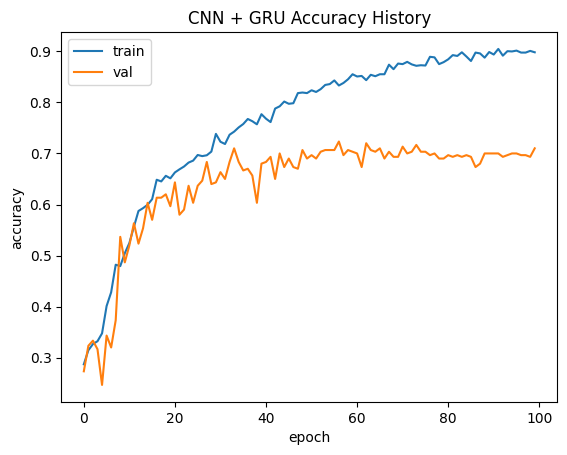

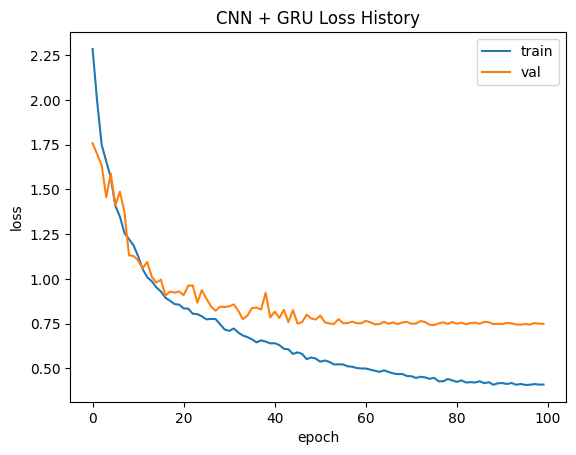

In [10]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN + GRU Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN + GRU Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [11]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 0.806, Test acc: 0.677


## CNN + GRU3
1 GRU block and 3 Convolutional blocks achieve 72% accuracy

In [12]:
class CNNGRU3(nn.Module):
    def __init__(self):
        super(CNNGRU3, self).__init__()

        # start: 22 x 500
        self.gru1 = SmallBlock(22, 128, dropout=True, norm=True)
        self.cblock1 = SmallConvBlock(128, 256, 5, dropout=True, norm=False)
        self.cblock2 = SmallConvBlock(256, 512, 5, dropout=True, norm=False)
        self.cblock3 = SmallConvBlock(512, 1024, 5, dropout=True, norm=True)
        self.output = nn.Linear(1024 * 6, 4)

    def forward(self, x):

        x = x.permute(0, 2, 1)
        x = self.gru1(x)

        x = x.permute (0, 2, 1)
        x = self.cblock1(x)
        x = self.cblock2(x)
        x = self.cblock3(x)
        x = x.reshape(x.size(0), -1)

        x = self.output(x)
        return x

def weights_init(m):
    if isinstance(m, (nn.GRU, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

In [13]:
model = CNNGRU3().to(device)
bsz, num_channels, width = 64, 22, 500
test_input = torch.randn(bsz, num_channels, width).to(device)

print(model(test_input).shape)

model.apply(weights_init)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

num_epochs = 100
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()


    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")

torch.Size([64, 4])
Epoch 1, Train loss: 2.474, Train acc: 0.307, Val loss: 1.867, Val acc: 0.227
Epoch 2, Train loss: 2.084, Train acc: 0.353, Val loss: 2.133, Val acc: 0.233
Epoch 3, Train loss: 1.644, Train acc: 0.425, Val loss: 1.401, Val acc: 0.417
Epoch 4, Train loss: 1.481, Train acc: 0.459, Val loss: 1.635, Val acc: 0.363
Epoch 5, Train loss: 1.335, Train acc: 0.475, Val loss: 1.258, Val acc: 0.467
Epoch 6, Train loss: 1.310, Train acc: 0.504, Val loss: 1.093, Val acc: 0.553
Epoch 7, Train loss: 1.193, Train acc: 0.508, Val loss: 1.037, Val acc: 0.553
Epoch 8, Train loss: 1.159, Train acc: 0.531, Val loss: 1.018, Val acc: 0.573
Epoch 9, Train loss: 1.078, Train acc: 0.565, Val loss: 0.998, Val acc: 0.587
Epoch 10, Train loss: 1.021, Train acc: 0.585, Val loss: 1.012, Val acc: 0.597
Epoch 11, Train loss: 0.969, Train acc: 0.606, Val loss: 1.109, Val acc: 0.530
Epoch 12, Train loss: 0.959, Train acc: 0.607, Val loss: 0.904, Val acc: 0.613
Epoch 13, Train loss: 0.916, Train acc: 0

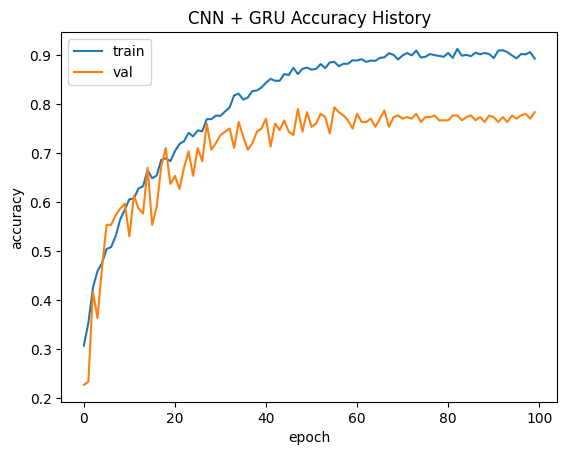

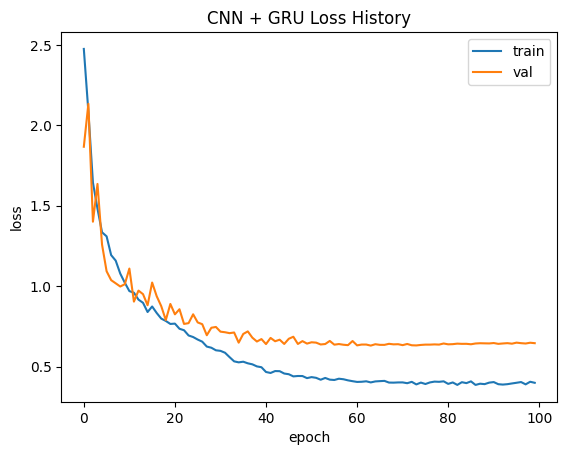

In [14]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN + GRU Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN + GRU Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")

Test loss: 0.696, Test acc: 0.720
